# Libraries

In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import r2_score

# visualization
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline

# preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# models
import statsmodels.api as sm
from statsmodels.formula.api import ols

---

# 3.27 Predicting Car Prices

Multiple regression: Multiple independent variables. Example- predicting price of car based on body style, brand, mileage, etc.

Multi**variate** regression: Multiple dependent variables (things you're trying to predict)

Based on the EDA below, summary of plan to predict price:
- ohe Make, Type
- independent vars: mileage, make, type, cylinders, doors, cruise, leather
- re doors: once ohe type, and scale the df, see correlation between doors and type. this could be multcol.
- linreg price vs mileage, make, cylinders?

In [2]:
cars = pd.read_excel('http://cdn.sundog-soft.com/Udemy/DataScience/cars.xls')
cars.head()

,Price,Mileage,Make,Model,Trim,Type,Cylinder,Liter,Doors,Cruise,Sound,Leather
0,17314.103129,8221,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,1
1,17542.036083,9135,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
2,16218.847862,13196,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
3,16336.913140,16342,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,0
4,16339.170324,19832,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,1


In [3]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804 entries, 0 to 803
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     804 non-null    float64
 1   Mileage   804 non-null    int64  
 2   Make      804 non-null    object 
 3   Model     804 non-null    object 
 4   Trim      804 non-null    object 
 5   Type      804 non-null    object 
 6   Cylinder  804 non-null    int64  
 7   Liter     804 non-null    float64
 8   Doors     804 non-null    int64  
 9   Cruise    804 non-null    int64  
 10  Sound     804 non-null    int64  
 11  Leather   804 non-null    int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 75.5+ KB


In [4]:
cars.describe()

,Price,Mileage,Cylinder,Liter,Doors,Cruise,Sound,Leather
count,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000
mean,21343.143767,19831.934080,5.268657,3.037313,3.527363,0.752488,0.679104,0.723881
std,9884.852801,8196.319707,1.387531,1.105562,0.850169,0.431836,0.467111,0.447355
min,8638.930895,266.000000,4.000000,1.600000,2.000000,0.000000,0.000000,0.000000
25%,14273.073870,14623.500000,4.000000,2.200000,4.000000,1.000000,0.000000,0.000000
50%,18024.995019,20913.500000,6.000000,2.800000,4.000000,1.000000,1.000000,1.000000
75%,26717.316636,25213.000000,6.000000,3.800000,4.000000,1.000000,1.000000,1.000000
max,70755.466717,50387.000000,8.000000,6.000000,4.000000,1.000000,1.000000,1.000000


In [5]:
corr = cars.corr()
corr

,Price,Mileage,Cylinder,Liter,Doors,Cruise,Sound,Leather
Price,1.000000,-0.143051,0.569086,0.558146,-0.138750,0.430851,-0.124348,0.157197
Mileage,-0.143051,1.000000,-0.029461,-0.018641,-0.016944,0.025037,-0.026146,0.001005
Cylinder,0.569086,-0.029461,1.000000,0.957897,0.002206,0.354285,-0.089704,0.075520
Liter,0.558146,-0.018641,0.957897,1.000000,-0.079259,0.377509,-0.065527,0.087332
Doors,-0.138750,-0.016944,0.002206,-0.079259,1.000000,-0.047674,-0.062530,-0.061969
Cruise,0.430851,0.025037,0.354285,0.377509,-0.047674,1.000000,-0.091730,-0.070573
Sound,-0.124348,-0.026146,-0.089704,-0.065527,-0.062530,-0.091730,1.000000,0.165444
Leather,0.157197,0.001005,0.075520,0.087332,-0.061969,-0.070573,0.165444,1.000000


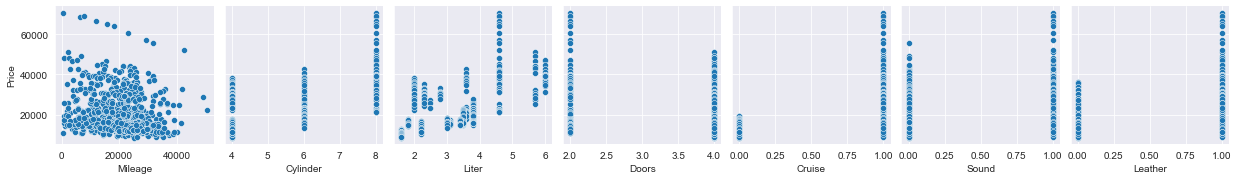

In [20]:
sns.pairplot(data=cars, 
             y_vars=['Price'], 
             x_vars=list(cars.select_dtypes([np.number]).columns[1:])); # list of numerical columns within cars dataframe

In [ ]:
# Had to do the following bc there was a bug in Seabon version 0.11.0 where it was graphing all the x_vars cols except the first one.

# checking seaborn version with following command:
# sns.__version__

# version I had: 0.11.0. Latest version: 0.11.1. Ran following command to update seaborn:
# pip install seaborn --upgrade

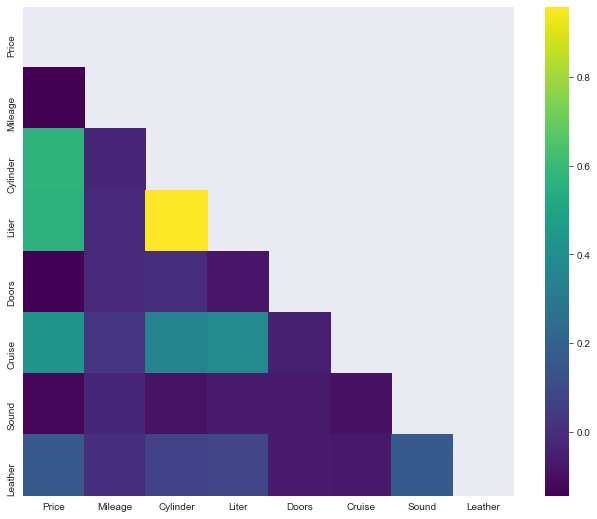

In [6]:
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, ax=ax, cmap="viridis");

I'm surprised mileage isn't more correlated with price, so let's check it out below:

### Mileage vs Price

In [ ]:
plt.scatter(cars.Mileage, cars.Price);

In [ ]:
sns.lmplot(data=cars, x='Mileage', y='Price');

In [ ]:
# LM Plot for the entire price vs mileage data

sns.lmplot(data=cars, x='Mileage', y='Price', hue='Make')
plt.title('all makes');

In [ ]:
# LM Plot, by make, Milieage vs Price

car_makes = ['Buick', 'Cadillac', 'Chevrolet', 'Pontiac', 'SAAB', 'Saturn']

for car_make in car_makes:
    sns.lmplot(data=cars[cars.Make == car_make], x='Mileage', y='Price', height=3, aspect=2, 
               hue='Cylinder', palette={4:'g', 6:'b', 8:'orange'}) 
    plt.title(car_make);

In [ ]:
cylinders = [8, 6, 4]

for cylinder in cylinders:
    sns.lmplot(data=cars[cars.Cylinder == cylinder], x='Mileage', y='Price', height=3, aspect=2, hue='Make',
               hue_order=car_makes)
    plt.title(f'{cylinder} cylinders');

So there IS a correlation between mileage and price,

In [ ]:
sns.boxplot(data=cars, x='Make', y='Price');

So, cruise and cylinder, both numerical values, have a relatively high positive correlation with price.

Let's look at type (categorical) and doors (numerical) real quick. 

I'm thinking ohe the categoricals, and then scale, and then we can do the linear regression.

Also, do a linear regression individually against features, and then altogether. And compare the difference.

In [ ]:
cars.head()

In [ ]:
cars.Trim.value_counts().head()

# discard this feature.

In [ ]:
cars.Type.unique()

#### New df with isolated features

In [ ]:
carsLinreg_df = cars[['Price', 'Mileage', 'Make', 'Type', 'Cylinder', 'Doors', 'Cruise', 'Leather']]
carsLinreg_df.sample(20)

In [ ]:
carsLinreg_df.describe()

In [ ]:
carsLinreg_df.info()

# OLS (udemy) vs ols (flatiron)

Looks like the ols (flatiron) one gives a y-intercept. Let's see

- going to use mileage, cylinders and doors

# OLS (udemy)

In [ ]:
# define feature and target variables
X = carsLinreg_df[['Mileage', 'Cylinder', 'Doors']]
y = carsLinreg_df[['Price']]

# scale features
ss = StandardScaler()
X_ss = pd.DataFrame(ss.fit_transform(X),
                    index= X.index,
                    columns= X.columns)

HOLY SHIT! When using OLS, we need to add a constant. I kept seeing the .add_constant method all over SOf but didn't know what or why people were adding it. Eventually it dawned on me that this might be the equivalent of the intercept in the ols. I tried it and voila! Now it matches the ols result...

In [ ]:
X_ss = sm.add_constant(X_ss)

X_ss.head()

In [ ]:
print(X_ss.max(), '\n'*2)
print(X_ss.min())

In [ ]:
# linreg
model_OLS = sm.OLS(y, X_ss).fit()
model_OLS.summary()

Predicting price for car with 45k miles, 8 cylinders and 4 doors using the model above.

Start by scaling your multiple feature variables into the same scale used to train the model, then just call est.predict() on the scaled features:

In [ ]:
help(sm.graphics.plot_regress_exog)

In [ ]:
X_ss.iloc[:,1:4].columns

In [ ]:
# flatiron youtube- Linear Regression 2 (43:04)

sm.graphics.plot_regress_exog(model_OLS, 'Doors', fig=plt.figure(figsize=(12,8)));

# Can only be graphed using ONE regressor or independent variable
# Understanding the assumptions will help with understanding the graphs below.

In [ ]:
# scaling the values we're trying to predict from against the scaled values of our model above
scaledPredicting = ss.transform([[45000, 8, 4]])

scaledPredicting

In [ ]:
scaledPredicting = sm.add_constant(scaledPredicting,has_constant='add')
scaledPredicting

In [ ]:
# predicting based on the scaled values we defined in the previous line above
OLS_prediction = model_OLS.predict(scaledPredicting)

print(OLS_prediction)

# ols (Flatiron)

We need to combine the price with the scaled values here in a new dataframe

In [ ]:
ols_fsm_df = y.join(X_ss.iloc[:,1:4])

ols_fsm_df.head()

In [ ]:
f = 'Price ~ Mileage + Cylinder + Doors'

model_ols = ols(formula= f, data= ols_fsm_df).fit()
model_ols.summary()


Let's make the same prediction from the ols model with the OLS model. Going to use the same params, which we already scaled above.

In [ ]:
# let's get the coef from our ols model

model_ols.params

In [ ]:
# isolating the coefs for mileage, cylinder, doors.
# IMPORTANT: these coefs are based on the scaled values of ea of those features. Not the actual.

model_ols.params[1:4]

In [ ]:
#scaled values of 45k, 8 cylinders, and 4 doors

print(scaledPredicting[0][1:4])

In [ ]:
print('ss val of 45k miles= ', scaledPredicting[0][1], 
      '\nmodel coef for miles=', model_ols.params[1])

print('45k miles affect on price:', scaledPredicting[0][1] * model_ols.params[1])

In [ ]:
model_ols.params[1:4]

In [ ]:
eaFeature_pred = model_ols.params[1:4] * scaledPredicting[0][1:4]
eaFeature_pred

In [ ]:
eaFeature_predSum = sum(model_ols.params[1:4] * scaledPredicting[0][1:4])
eaFeature_predSum

In [ ]:
print(eaFeature_pred[0], eaFeature_pred[1], eaFeature_pred[2])
print(eaFeature_pred[0] + eaFeature_pred[1] + eaFeature_pred[2])

In [ ]:
model_ols.params[0] + eaFeature_predSum

---

I couldn't run the following code below:

pd.DataFrame(scaledPredicting[0][1:4], columns= ['Mileage', 'Cylinder', 'Doors'])

so the next few cells are me trying to figure out why. Turns out i had to surround scaledPredicting with hard brackets... I have pasted the link below

In [ ]:
scaledPredicting

In [ ]:
pd.DataFrame(scaledPredicting)

In [ ]:
scaledPredicting[0][1:4]

In [ ]:
pd.DataFrame([scaledPredicting[0][1:4]])

---

In [ ]:
# turns out I have to feed in a dataframe of scaled values to predict. It has to be a df, else it'll give an error
# I'm testing out how to make the dataframe here, and then feed it into the next cell for the prediction.
# https://stackoverflow.com/questions/45327069/convert-numpy-array-to-pandas-dataframe-column-wise-as-single-row

pd.DataFrame([scaledPredicting[0][1:4]], columns= ['Mileage', 'Cylinder', 'Doors'])

In [ ]:
ols_prediction = model_ols.predict(pd.DataFrame([scaledPredicting[0][1:4]], 
                                                columns= ['Mileage', 'Cylinder', 'Doors']))

ols_prediction

# OHE Make & Type

In [ ]:
carsLinreg_df.Make.unique()

In [ ]:
carsLinreg_df.Type.unique()

# OHE Make- Dropping first col

I'm going to add this back to price and run ols

In [ ]:
ohe = OneHotEncoder(drop='first')

oheMake = ohe.fit_transform(carsLinreg_df[['Make']])
oheMake.todense()

In [ ]:
ohe.get_feature_names()

In [ ]:
oheMakeDropped_df = pd.DataFrame(oheMake.todense(), 
                          index=carsLinreg_df.index, 
                          columns=ohe.get_feature_names(carsLinreg_df[['Make']].columns))

oheMakeDropped_df

In [ ]:
y

In [ ]:
ols_MakeDropped_df = y.join(oheMakeDropped_df)
ols_MakeDropped_df

In [ ]:
ols_MakeDropped_df.columns

In [ ]:
f = 'Price ~ Make_Cadillac + Make_Chevrolet + Make_Pontiac + Make_SAAB + Make_Saturn'

model_ols_MakeDropped = ols(formula= f, data= ols_MakeDropped_df).fit()
model_ols_MakeDropped.summary()

In [ ]:
model_ols_MakeDropped.params

# OHE Make- Keeping all cols

In [ ]:
carsLinreg_df

In [ ]:
ohe = OneHotEncoder()

oheMake = ohe.fit_transform(carsLinreg_df[['Make']])

oheMake_df = pd.DataFrame(oheMake.todense(), 
                          index=carsLinreg_df.index, 
                          columns=ohe.get_feature_names(carsLinreg_df[['Make']].columns))

oheMake_df

In [ ]:
ols_Make_df = y.join(oheMake_df)
ols_Make_df

In [ ]:
f = 'Price ~ Make_Buick + Make_Cadillac + Make_Chevrolet + Make_Pontiac + Make_SAAB + Make_Saturn'

model_ols_Make = ols(formula= f, data= ols_Make_df).fit()
model_ols_Make.summary()

In [ ]:
# Model params from dataframe with ALL dummy columns

model_ols_Make.params

In [ ]:
# Model params from dataframe with first dummy column dropped.

model_ols_MakeDropped.params

In [ ]:
# all intercept + Buick coef == dropped intercept

20009.237335 + 805.876548 == 20815.113883

In [ ]:
# all Cadillac coef - all Buick coef = dropped Cadillac coef

print(round(model_ols_Make.params[2], 6), '+', 
      round(model_ols_Make.params[1], 6), '=', 
      round(model_ols_MakeDropped.params[1], 6))

round(model_ols_Make.params[2] - model_ols_Make.params[1], 6) == round(model_ols_MakeDropped.params[1], 6)

OMG! It turns out that when you drop the first column, its coefs gets included into the coefs of the other features! Let's try this with type

So we're going to do the same to TYPE, and run ols on both all columns vs dropping first column, to get that coef.

# OHE Type

In [ ]:
ohe = OneHotEncoder()

oheType = ohe.fit_transform(carsLinreg_df[['Type']])

ohe_Type_df = pd.DataFrame(oheType.todense(), 
                           index= carsLinreg_df.index, 
                           columns= ohe.get_feature_names(carsLinreg_df[['Type']].columns))

ohe_Type_df

Joining ohe'd type feature to price:

In [ ]:
ohe_Type_df = y.join(ohe_Type_df)
ohe_Type_df

Let's model this bitch!

In [ ]:
# define formula:
f = 'Price ~ Type_Convertible + Type_Coupe + Type_Hatchback + Type_Sedan + Type_Wagon'

# model below:
olsType = ols(formula=f, data=ohe_Type_df).fit()
olsType.summary()

In [ ]:
olsType.params

# OHE TYPE, with first column dropped

In [ ]:
# instantiate OneHotEncorder
ohe = OneHotEncoder(drop='first')

# fit_transform the series of the feature
oheTypeDropped = ohe.fit_transform(carsLinreg_df[['Type']])

# create a df of the dummied columns
oheTypeDropped_df = pd.DataFrame(oheTypeDropped.todense(), 
                                 index=carsLinreg_df.index,
                                 columns=ohe.get_feature_names(carsLinreg_df[['Type']].columns))

oheTypeDropped_df

In [ ]:
# join price to dummied columns above
oheTypeDropped_df = y.join(oheTypeDropped_df)
oheTypeDropped_df

In [ ]:
# let's fuckin' model!

# define formula
f = 'Price ~ Type_Coupe + Type_Hatchback + Type_Sedan + Type_Wagon'

# model
olsTypeDropped = ols(formula=f, data=oheTypeDropped_df).fit()
olsTypeDropped.summary()

In [ ]:
olsType.params

In [ ]:
olsTypeDropped.params

Let's compare the two above:

In [ ]:
# olsType intercept + olsTyple Convertible = olsTypeDropped intercept
## had to round bc the answer up to 6 decimal place is the same. 

round(19442.789722 + 21388.916125, 6) == 40831.705847

In [ ]:
# all couple - all convertible = dropped coupe
round(-1715.857890 - 21388.916125, 4) == round(-23104.774016, 4)

So, given the above stuff, we can see that the coef of the dropped category is just eaten up by the coefs of the other categories! 

So now let's go ahead and combine the 2 catgories, Make and Type, OHE all categories, 

# Joining y with type and make

Had to drop Price from ohe_Type_df since it was causing an error with the .join funtion

In [ ]:
# ohe_Type_df.drop(['Price'], axis=1, inplace=True)
ohe_Type_df

In [ ]:
oheMake_df

In [ ]:
oheTypeMake_df = y.join([ohe_Type_df, oheMake_df])
oheTypeMake_df

Now that we have our dataframe above, with the price against the ohe'd type and make, let's model using OLS.

In [ ]:
oheTypeMake_df.columns

In [ ]:
for x in oheTypeMake_df.columns:
    print(x, '+')

In [ ]:
# let's fuckin' model!

# define formula
f = 'Price ~ Type_Convertible +Type_Coupe +Type_Hatchback +Type_Sedan +Type_Wagon +Make_Buick +Make_Cadillac +Make_Chevrolet +Make_Pontiac +Make_SAAB +Make_Saturn'

# model
olsTypeMake = ols(formula=f, data=oheTypeMake_df).fit()
olsTypeMake.summary()

In [ ]:
olsTypeMake.params

**Predicting cost of car:**

car type: convertible
car make: cadillac

In [ ]:
pd.DataFrame([[1.0, 1.0]], columns=['Type_Convertible', 'Make_Cadillac'])

In [ ]:
olsTypeMake.predict(pd.DataFrame([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]], 
                                 columns=['Type_Convertible', 'Type_Coupe', 'Type_Hatchback', 
                                          'Type_Sedan', 'Type_Wagon', 'Make_Buick', 'Make_Cadillac', 
                                          'Make_Chevrolet', 'Make_Pontiac', 'Make_SAAB', 'Make_Saturn']))

In [ ]:
pd.DataFrame([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]], 
             columns=oheTypeMake_df.columns[1:])

In [ ]:
olsTypeMakeParmas = olsTypeMake.params
olsTypeMakeParmas[0] + olsTypeMakeParmas[1] + olsTypeMakeParmas[7]